### Прогноз размещения на площадке (отрасли + регионы закупок) 

In [72]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [73]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [74]:
data = pd.read_excel('ТоварыРегионыМесяц.xlsx')
data.head()

,UnKod,Регион,Section_num,Section,M1,M2,M3,M4,M5,M6,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,1701,Адыгея,17,Бумага и изделия из бумаги,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1702,Башкортостан,17,Бумага и изделия из бумаги,0,0,0,0,0,0,...,10,4,8,3,1,6,9,0,0,0
2,1703,Бурятия,17,Бумага и изделия из бумаги,2,13,12,9,7,4,...,10,12,10,10,4,5,5,0,0,0
3,1704,Алтай,17,Бумага и изделия из бумаги,3,8,7,7,7,5,...,16,17,7,10,5,9,2,0,0,0
4,1705,Дагестан,17,Бумага и изделия из бумаги,0,3,3,8,10,28,...,13,19,15,10,4,6,1,0,0,0


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 40 columns):
UnKod          5294 non-null int64
Регион         5294 non-null object
Section_num    5294 non-null object
Section        5294 non-null object
M1             5294 non-null int64
M2             5294 non-null int64
M3             5294 non-null int64
M4             5294 non-null int64
M5             5294 non-null int64
M6             5294 non-null int64
M7             5294 non-null int64
M8             5294 non-null int64
M9             5294 non-null int64
M10            5294 non-null int64
M11            5294 non-null int64
M12            5294 non-null int64
M13            5294 non-null int64
M14            5294 non-null int64
M15            5294 non-null int64
M16            5294 non-null int64
M17            5294 non-null int64
M18            5294 non-null int64
M19            5294 non-null int64
M20            5294 non-null int64
M21            5294 non-null int64
M22            

In [76]:
columns=['Section', 'Регион', 'Section_num']
data.drop(columns, axis=1, inplace=True)

In [77]:
melt = data.melt(id_vars='UnKod', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['UnKod', 'Month'])
melt.head()

,UnKod,Month,Proc
1631,102,1,0
6925,102,2,0
12219,102,3,0
17513,102,4,0
22807,102,5,0


In [78]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['UnKod'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['UnKod'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,UnKod,Month,Proc,Last_Month_Proc,Last_Month_Diff
12219,102,3,0,0.0,0.0
17513,102,4,0,0.0,0.0
22807,102,5,0,0.0,0.0
28101,102,6,0,0.0,0.0
33395,102,7,0,0.0,0.0


In [79]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179996 entries, 12219 to 187361
Data columns (total 5 columns):
UnKod              179996 non-null int64
Month              179996 non-null int32
Proc               179996 non-null int64
Last_Month_Proc    179996 non-null float64
Last_Month_Diff    179996 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 7.6 MB


In [80]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [81]:
import copy

In [82]:
procedures = []
for Month in range(0,30):
    val=melt2[melt2['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [83]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))

Month 30 - Error 0.63038, Real Total 44141.0 - Predict Total 43152.0, Abs Error 989.0
Month 31 - Error 0.66036, Real Total 32368.0 - Predict Total 44141.0, Abs Error 11773.0
Month 32 - Error 0.62912, Real Total 40760.0 - Predict Total 32368.0, Abs Error 8392.0
Mean Error = 0.63996
Mean Abs Error = 7051.33333
Wall time: 47.4 ms


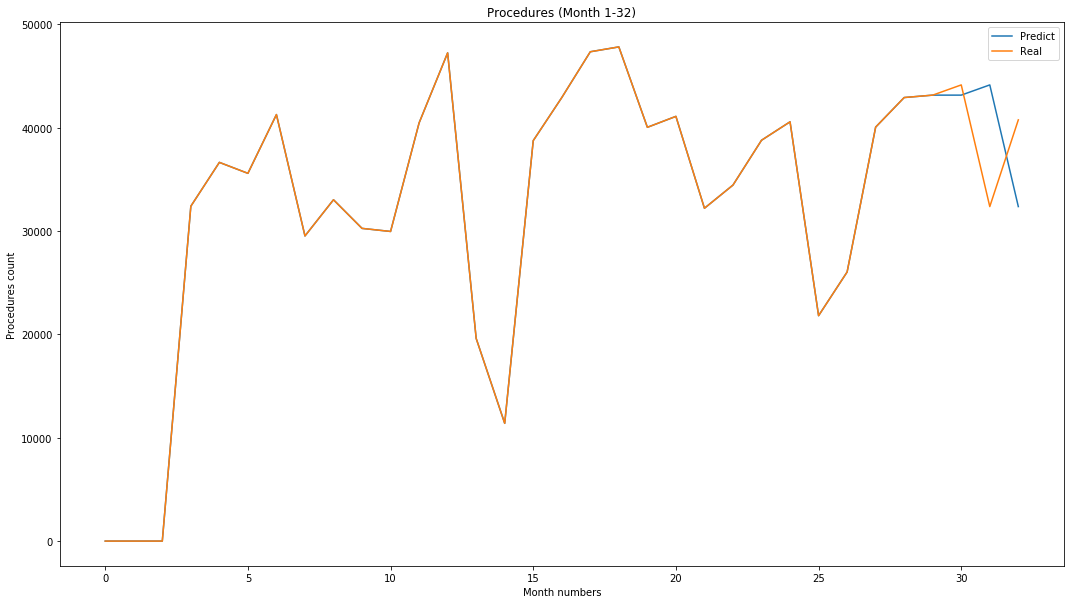

In [84]:

plt.plot(predict_ProcB)
plt.plot(ProcB)
plt.title('Procedures (Month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

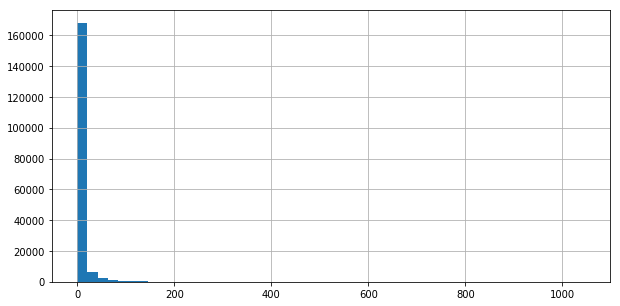

In [85]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [86]:
%%time
mean_error2 = []
total_error2 = []
Proc2 = copy.copy(procedures)
predict_Proc2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_error2.append(error)
    total_error2.append(abs_error)
    Proc2.append(total_yts)
    predict_Proc2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_error2))
print('Mean Abs Error = %.5f' % np.mean(total_error2))

Month 30 - Error 0.68882, Real Total 44141.0 - Predict Total 42763.2, Abs Error 1377.8
Month 31 - Error 0.75751, Real Total 32368.0 - Predict Total 43728.8, Abs Error 11360.8
Month 32 - Error 0.63527, Real Total 40760.0 - Predict Total 33827.4, Abs Error 6932.6
Mean Error = 0.69387
Mean Abs Error = 6557.05070
Wall time: 177 ms


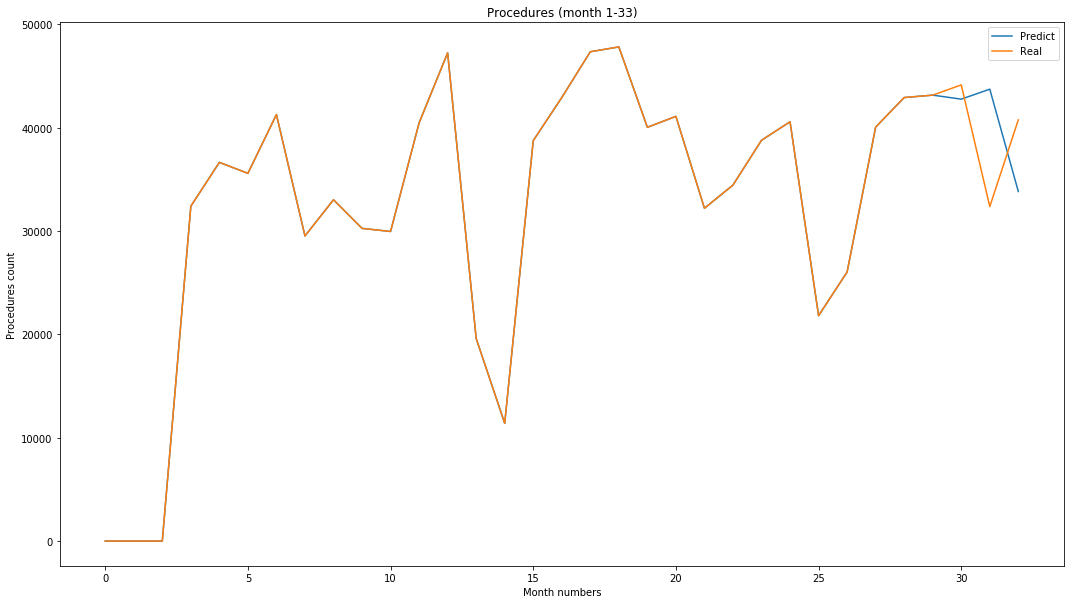

In [87]:

plt.plot(predict_Proc2)
plt.plot(Proc2)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [88]:
%%time
mean_errorRF2 = []
total_errorRF2 = []
ProcRF2 = copy.copy(procedures)
predict_ProcRF2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF2.append(error)
    total_errorRF2.append(abs_error)
    ProcRF2.append(total_yts)
    predict_ProcRF2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF2))

Month 30 - Error 0.64512, Real Total 44141.0 - Predict Total 46430.6, Abs Error 2289.6
Month 31 - Error 0.69607, Real Total 32368.0 - Predict Total 46445.6, Abs Error 14077.6
Month 32 - Error 0.60029, Real Total 40760.0 - Predict Total 32648.6, Abs Error 8111.4
Mean Error = 0.64716
Mean Abs Error = 8159.51233
Wall time: 9min 57s


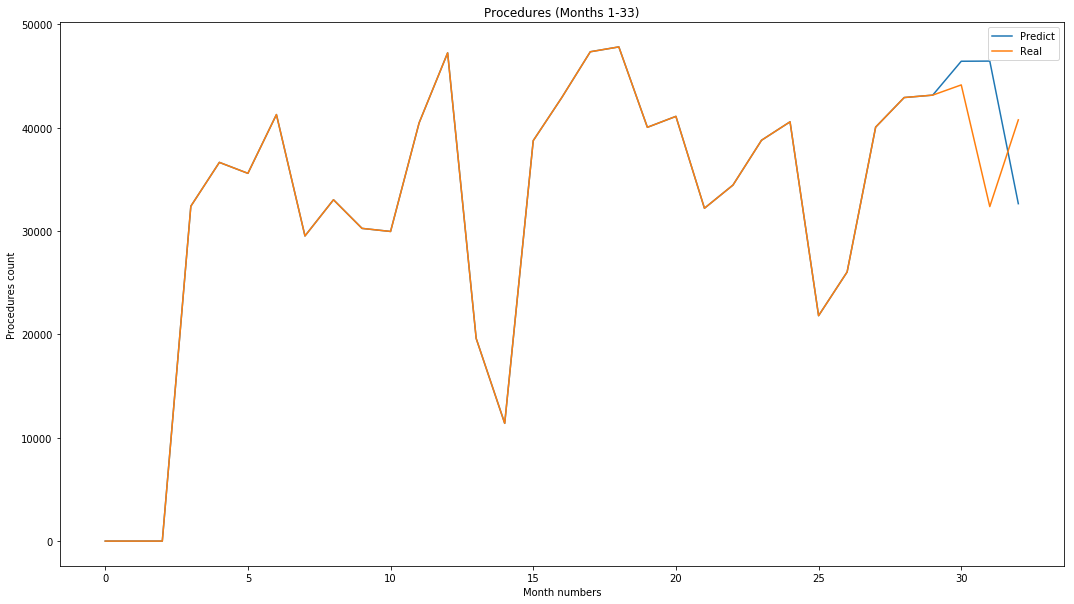

In [89]:

plt.plot(predict_ProcRF2)
#plt.plot(ProcRF2)
plt.plot(ProcB)
plt.title('Procedures (Months 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [90]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['UnKod'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['UnKod'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['UnKod'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['UnKod'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,UnKod,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
17513,102,4,0,0.0,0.0,0.0,0.0
22807,102,5,0,0.0,0.0,0.0,0.0
28101,102,6,0,0.0,0.0,0.0,0.0
33395,102,7,0,0.0,0.0,0.0,0.0
38689,102,8,0,0.0,0.0,0.0,0.0


In [91]:
%%time
mean_errorRF3 = []
total_errorRF3 = []
ProcRF3 = copy.copy(procedures)
predict_ProcRF3 = copy.copy(procedures)
for Month in range(30,33):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF3.append(error)
    total_errorRF3.append(abs_error)
    ProcRF3.append(total_yts)
    predict_ProcRF3.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF3))

Month 30 - Error 0.65675, Real Total 44141.0 - Predict Total 48939.7, Abs Error 4798.7
Month 31 - Error 0.69871, Real Total 32368.0 - Predict Total 47022.6, Abs Error 14654.6
Month 32 - Error 0.59527, Real Total 40760.0 - Predict Total 34251.1, Abs Error 6508.9
Mean Error = 0.65024
Mean Abs Error = 8654.06367
Wall time: 11min 19s


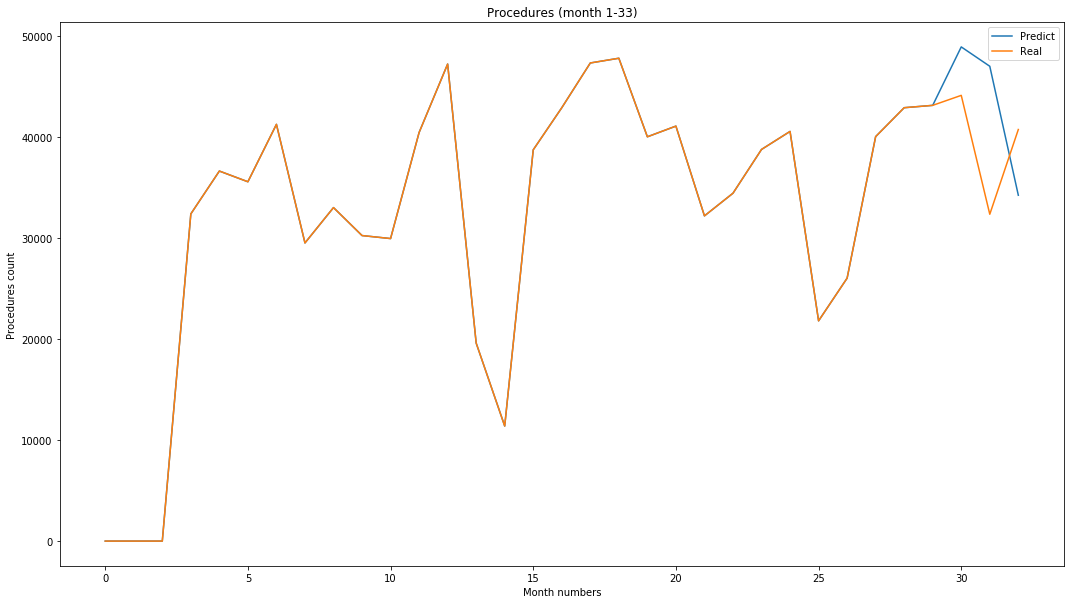

In [92]:

plt.plot(predict_ProcRF3)
plt.plot(ProcRF3)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [93]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['UnKod'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['UnKod'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['UnKod'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,UnKod,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
22807,102,5,0,0.0,0.0,0.0,0.0,0.0,0.0
28101,102,6,0,0.0,0.0,0.0,0.0,0.0,0.0
33395,102,7,0,0.0,0.0,0.0,0.0,0.0,0.0
38689,102,8,0,0.0,0.0,0.0,0.0,0.0,0.0
43983,102,9,0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
%%time
mean_errorRF4 = []
total_errorRF4 = []
ProcRF4 = copy.copy(procedures)
predict_ProcRF4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF4.append(error)
    total_errorRF4.append(abs_error)
    ProcRF4.append(total_yts)
    predict_ProcRF4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4))

Month 30 - Error 0.65400, Real Total 44141.0 - Predict Total 48576.1, Abs Error 4435.1
Month 31 - Error 0.72258, Real Total 32368.0 - Predict Total 47855.8, Abs Error 15487.8
Month 32 - Error 0.59561, Real Total 40760.0 - Predict Total 34855.4, Abs Error 5904.6
Mean Error = 0.65739
Mean Abs Error = 8609.20167
Wall time: 13min 18s


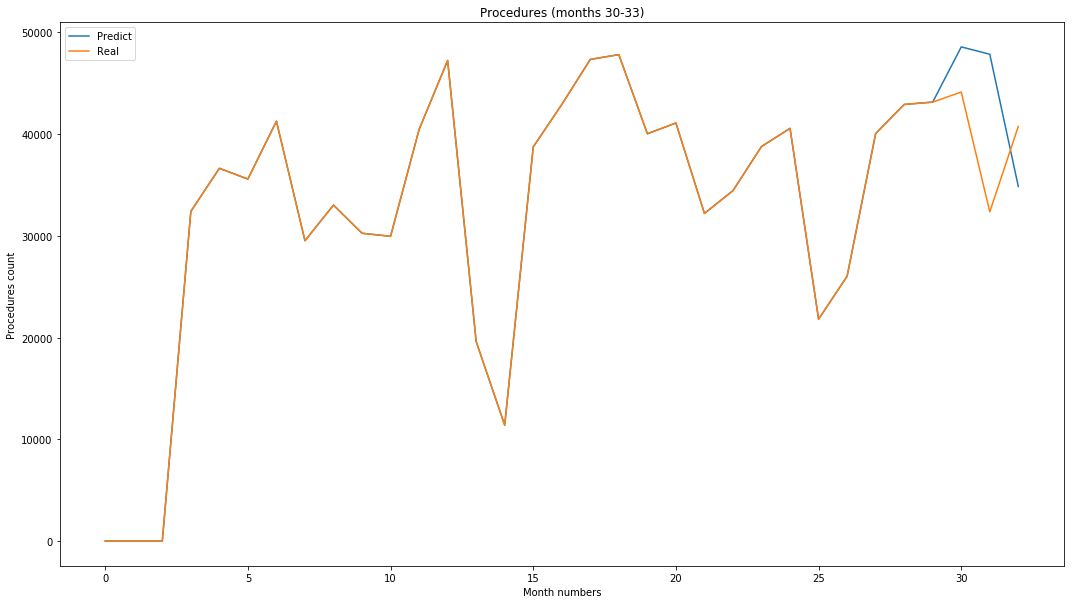

In [95]:

plt.plot(predict_ProcRF4)
plt.plot(ProcRF4)
plt.title('Procedures (months 30-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [96]:
%%time
mean_errorGB4 = []
total_errorGB4 = []
ProcGB4 = copy.copy(procedures)
predict_ProcGB4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    #print('Month %d - Error %.5f' % (Month, error))
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB4.append(error)
    total_errorGB4.append(abs_error)
    ProcGB4.append(total_yts)
    predict_ProcGB4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB4))

Month 30 - Error 0.53024, Real Total 44141.0 - Predict Total 39444.1, Abs Error 4696.9
Month 31 - Error 0.56812, Real Total 32368.0 - Predict Total 40301.0, Abs Error 7933.0
Month 32 - Error 0.56467, Real Total 40760.0 - Predict Total 24769.7, Abs Error 15990.3
Mean Error = 0.55435
Mean Abs Error = 9540.05155
Wall time: 28.8 s


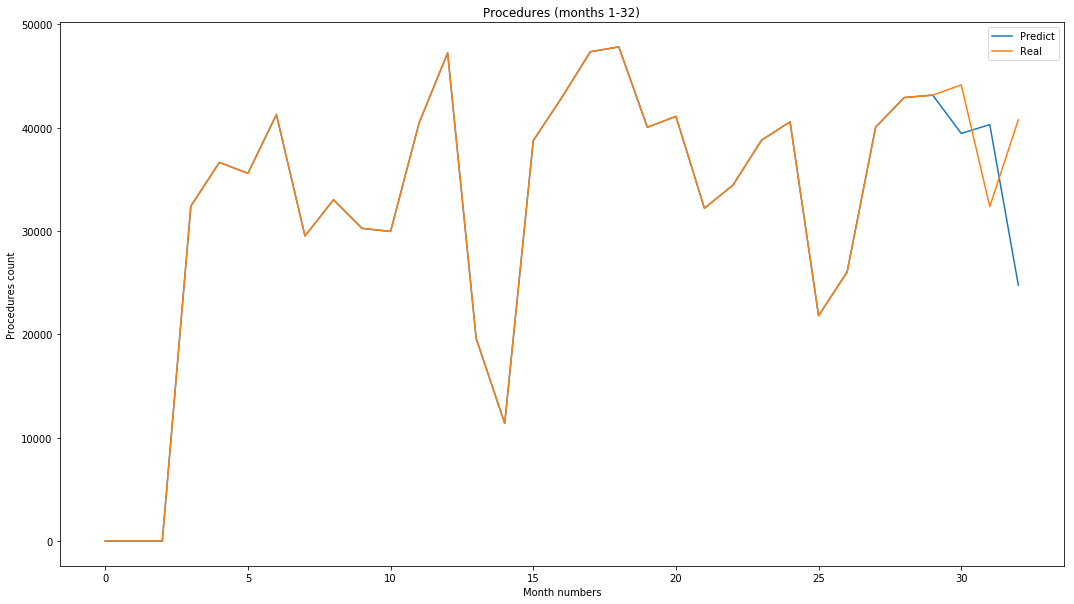

In [97]:

plt.plot(predict_ProcGB4)
plt.plot(ProcGB4)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [98]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['UnKod'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['UnKod'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['UnKod'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['UnKod'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['UnKod'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['UnKod'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['UnKod'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['UnKod'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['UnKod'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['UnKod'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['UnKod'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['UnKod'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['UnKod'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['UnKod'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 11.1 s


In [99]:
%%time
mean_errorRF12 = []
total_errorRF12 = []
ProcRF12 = copy.copy(procedures)
predict_ProcRF12 = copy.copy(procedures)
for Month in range(30, 33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF12.append(error)
    total_errorRF12.append(abs_error)
    ProcRF12.append(total_yts)
    predict_ProcRF12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))

Month 30 - Error 0.65524, Real Total 44141.0 - Predict Total 48541.8, Abs Error 4400.8
Month 31 - Error 0.72415, Real Total 32368.0 - Predict Total 47900.2, Abs Error 15532.2
Month 32 - Error 0.59641, Real Total 40760.0 - Predict Total 34876.1, Abs Error 5883.9
Mean Error = 0.65860
Mean Abs Error = 8605.63900
Wall time: 30min 12s


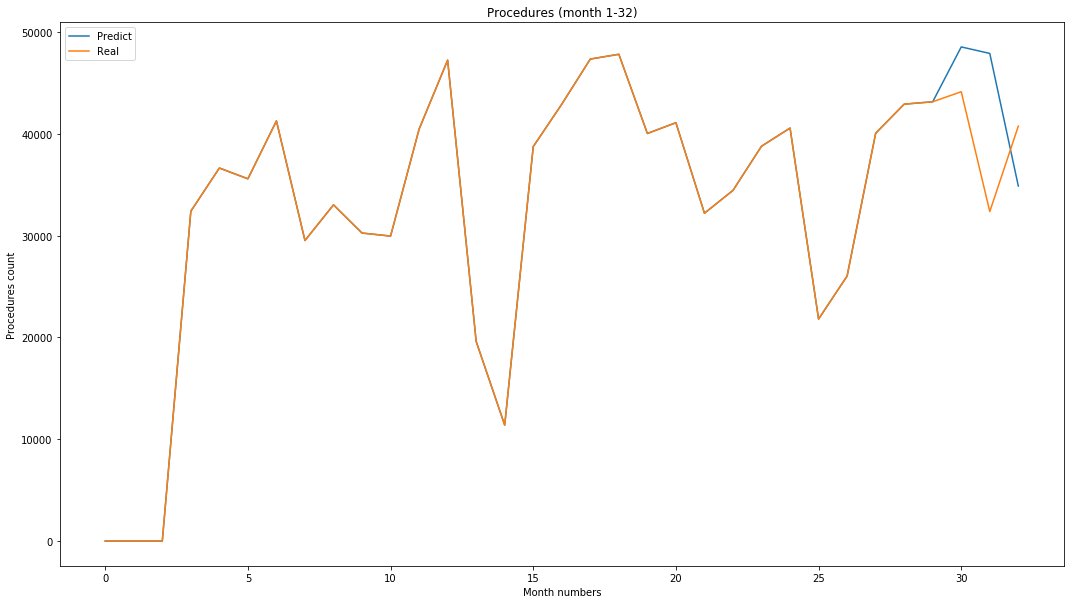

In [100]:

plt.plot(predict_ProcRF12)
plt.plot(ProcRF12)
plt.title('Procedures (month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [101]:
%%time
mean_errorGB12 = []
total_errorGB12 = []
ProcGB12 = copy.copy(procedures)
predict_ProcGB12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB12.append(error)
    total_errorGB12.append(abs_error)
    ProcGB12.append(total_yts)
    predict_ProcGB12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB12))

Month 30 - Error 0.53024, Real Total 44141.0 - Predict Total 39444.1, Abs Error 4696.9
Month 31 - Error 0.56812, Real Total 32368.0 - Predict Total 40301.0, Abs Error 7933.0
Month 32 - Error 0.56467, Real Total 40760.0 - Predict Total 24769.7, Abs Error 15990.3
Mean Error = 0.55435
Mean Abs Error = 9540.05155
Wall time: 1min 10s


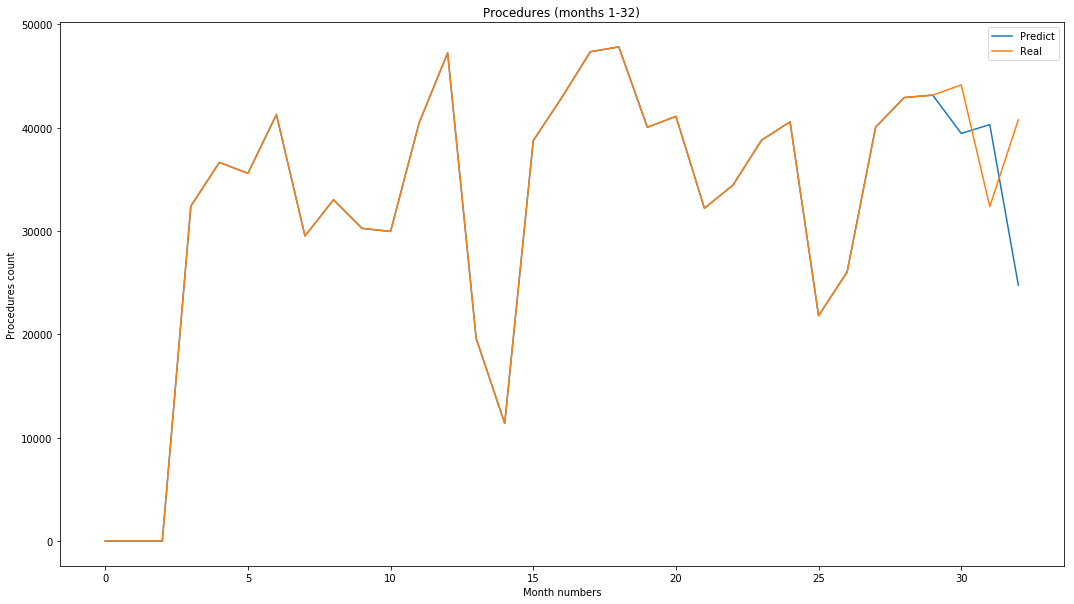

In [102]:

plt.plot(predict_ProcGB12)
plt.plot(ProcGB12)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [103]:
%%time
mean_errorLR12 = []
total_errorLR12 = []
ProcLR12 = copy.copy(procedures)
predict_ProcLR12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR12.append(error)
    total_errorLR12.append(abs_error)
    ProcLR12.append(total_yts)
    predict_ProcLR12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR12))

Month 30 - Error 0.69236, Real Total 44141.0 - Predict Total 42408.7, Abs Error 1732.3
Month 31 - Error 0.78300, Real Total 32368.0 - Predict Total 44768.7, Abs Error 12400.7
Month 32 - Error 0.64083, Real Total 40760.0 - Predict Total 35793.5, Abs Error 4966.5
Mean Error = 0.70539
Mean Abs Error = 6366.49412
Wall time: 975 ms


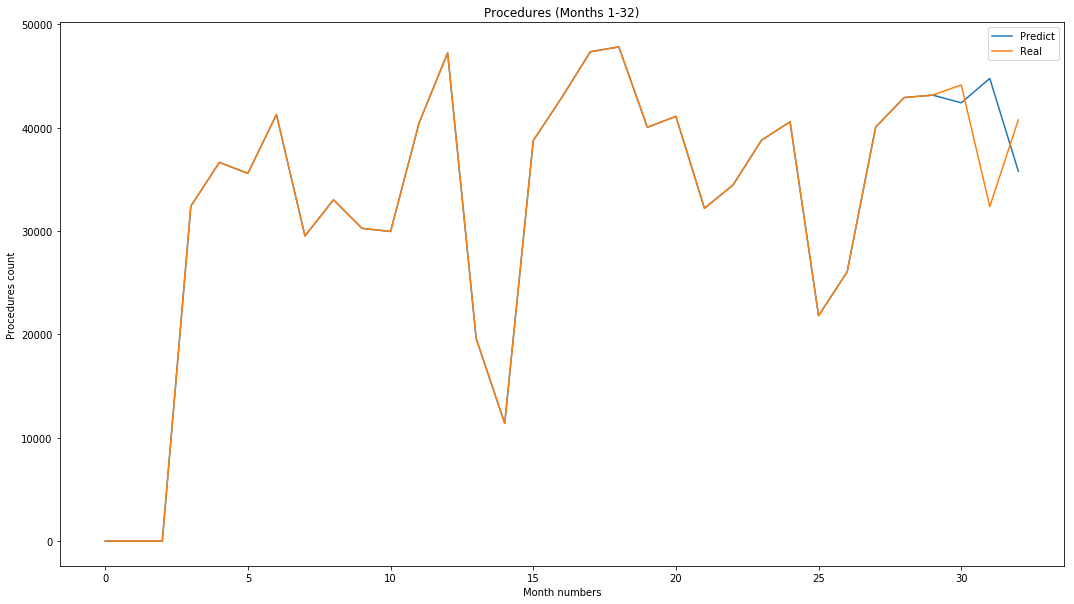

In [104]:

plt.plot(predict_ProcLR12)
plt.plot(ProcLR12)
plt.title('Procedures (Months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


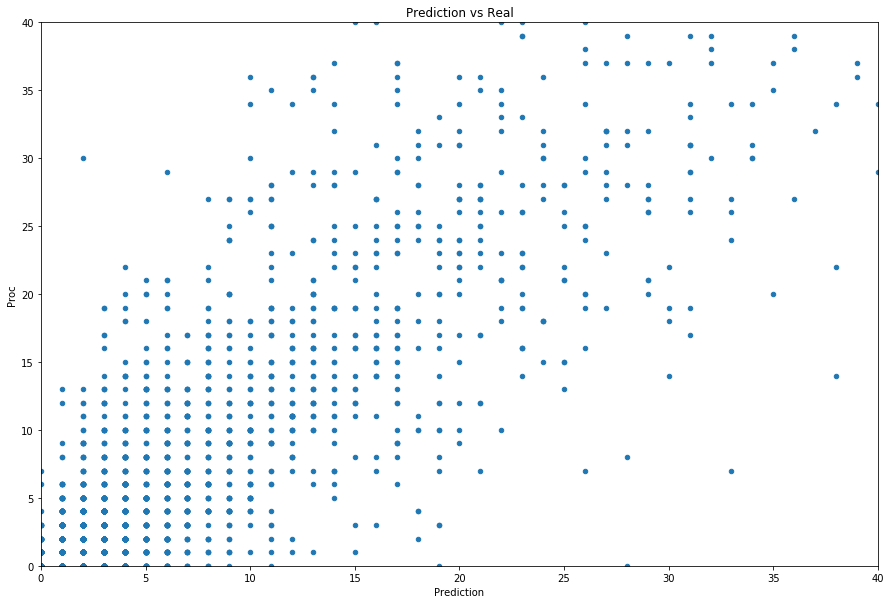

In [105]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,40), xlim=(0,40))

In [106]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['UnKod'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['UnKod'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['UnKod'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['UnKod'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['UnKod'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['UnKod'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['UnKod'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['UnKod'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['UnKod'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['UnKod'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['UnKod'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['UnKod'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['UnKod'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['UnKod'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['UnKod'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['UnKod'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['UnKod'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['UnKod'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['UnKod'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['UnKod'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['UnKod'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['UnKod'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['UnKod'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['UnKod'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['UnKod'])['Proc'].shift(3)
melt24 = melt24.dropna()
melt24.head()

Wall time: 27.6 s


In [107]:
%%time
mean_errorRF24 = []
total_errorRF24 = []
ProcRF24 = copy.copy(procedures)
predict_ProcRF24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF24.append(error)
    total_errorRF24.append(abs_error)
    ProcRF24.append(total_yts)
    predict_ProcRF24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))

Month 30 - Error 0.65555, Real Total 44141.0 - Predict Total 48582.9, Abs Error 4441.9
Month 31 - Error 0.72467, Real Total 32368.0 - Predict Total 47899.1, Abs Error 15531.1
Month 32 - Error 0.59642, Real Total 40760.0 - Predict Total 34898.8, Abs Error 5861.2
Mean Error = 0.65888
Mean Abs Error = 8611.38833
Wall time: 51min 40s


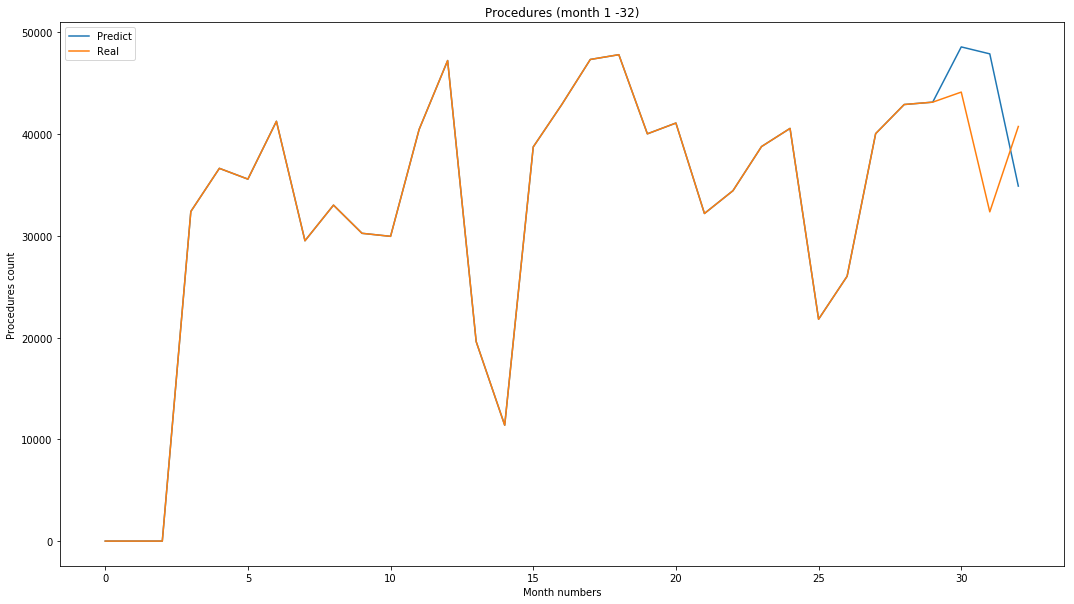

In [108]:

plt.plot(predict_ProcRF24)
plt.plot(ProcRF24)
plt.title('Procedures (month 1 -32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [109]:
%%time
mean_errorGB24 = []
total_errorGB24 = []
ProcGB24 = copy.copy(procedures)
predict_ProcGB24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB24.append(error)
    total_errorGB24.append(abs_error)
    ProcGB24.append(total_yts)
    predict_ProcGB24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB24))

Month 30 - Error 0.53024, Real Total 44141.0 - Predict Total 39444.1, Abs Error 4696.9
Month 31 - Error 0.56812, Real Total 32368.0 - Predict Total 40301.0, Abs Error 7933.0
Month 32 - Error 0.56467, Real Total 40760.0 - Predict Total 24769.7, Abs Error 15990.3
Mean Error = 0.55435
Mean Abs Error = 9540.05155
Wall time: 1min 38s


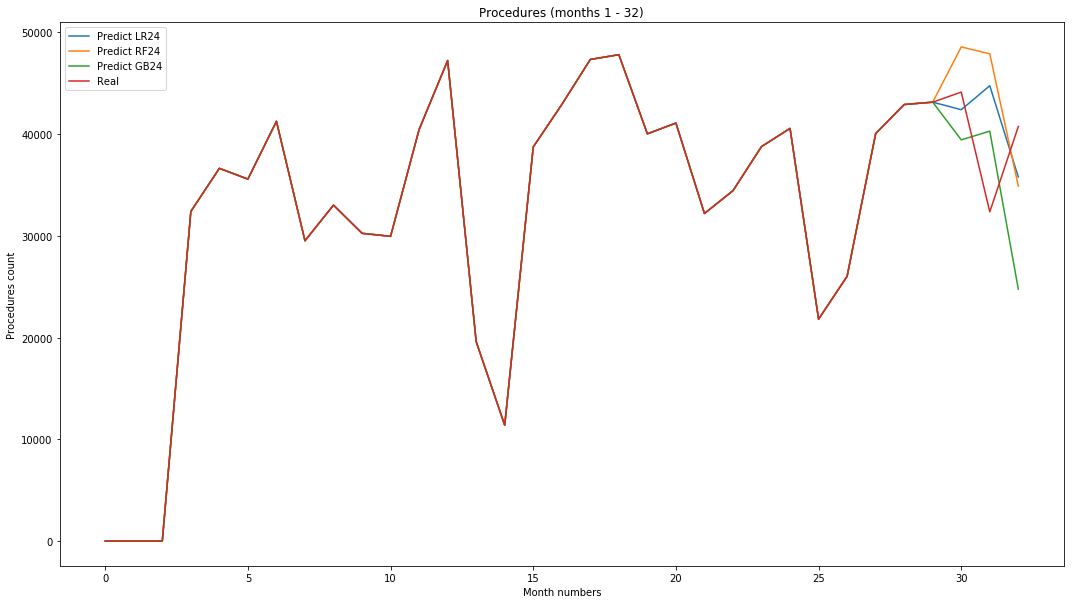

In [113]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(ProcGB24)

plt.title('Procedures (months 1 - 32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict LR24', 'Predict RF24', 'Predict GB24', 'Real'))

In [111]:
%%time
mean_errorLR24 = []
total_errorLR24 = []
ProcLR24 = copy.copy(procedures)
predict_ProcLR24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR24.append(error)
    total_errorLR24.append(abs_error)
    ProcLR24.append(total_yts)
    predict_ProcLR24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR24))

Month 30 - Error 0.69236, Real Total 44141.0 - Predict Total 42408.7, Abs Error 1732.3
Month 31 - Error 0.78300, Real Total 32368.0 - Predict Total 44768.7, Abs Error 12400.7
Month 32 - Error 0.64083, Real Total 40760.0 - Predict Total 35793.5, Abs Error 4966.5
Mean Error = 0.70539
Mean Abs Error = 6366.49412
Wall time: 1.65 s


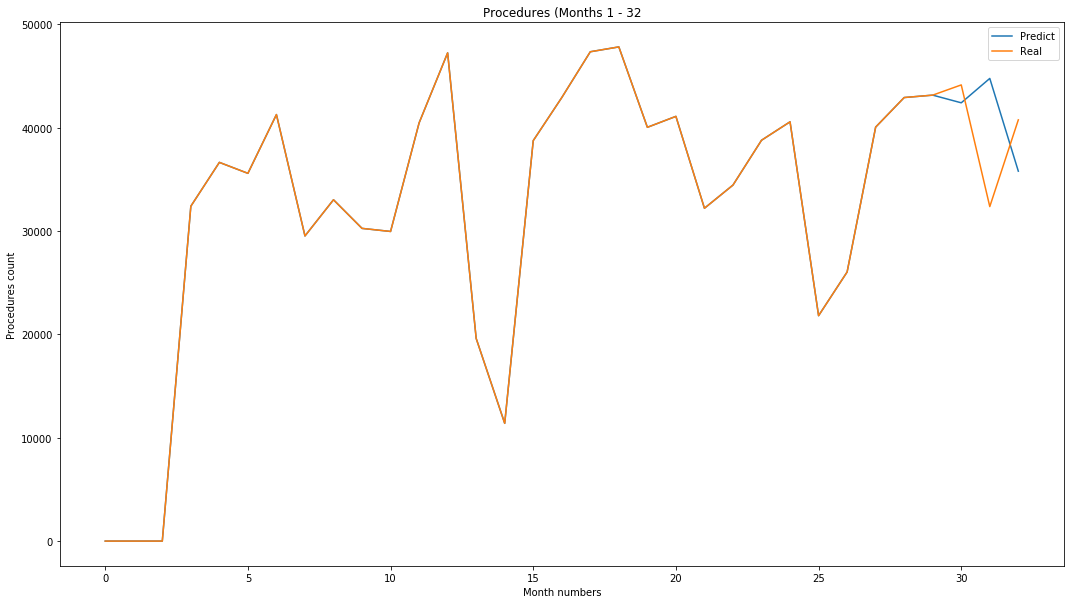

In [112]:

plt.plot(predict_ProcLR24)
plt.plot(ProcLR24)
plt.title('Procedures (Months 1 - 32')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))